<a href="https://colab.research.google.com/github/sameer91/8th_sem/blob/master/brain2_mask_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!cp drive/My\ Drive/brain_dataset/rgb_npy/{images.npy,labels.npy,masks.npy} ./

In [2]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping


init_notebook_mode(connected=True)
RANDOM_SEED = 123


Using TensorFlow backend.


In [0]:
x = np.load('images.npy')
y = np.load('labels.npy')
masks = np.load('masks.npy')

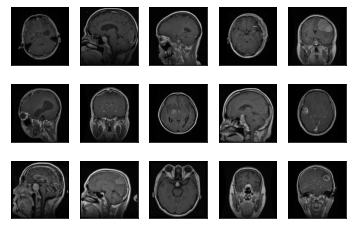

In [3]:
plt.figure()

for i in range(3):
  for j in range(5):
    plt.subplot(3, 5, 1+i*5+j)
    plt.imshow(x[i*5+j])
    plt.xticks([])
    plt.yticks([])

plt.show()

In [0]:
new_masks = []
for mask in masks:
  mask = mask.astype('uint8')
  mask = [ele*255 for ele in mask]
  new_masks.append(np.array(mask))

In [0]:
cnts = cv2.findContours(new_masks[4].copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

test_img = x[4][extTop[1]-40:extBot[1]+40,
              extLeft[0]-40:extRight[0]+40].copy()

Text(0.5, 1.0, '3. Crop Tumor with padding=40px')

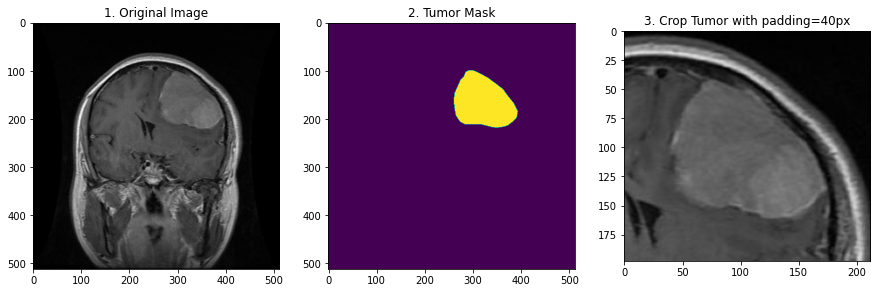

In [66]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.imshow(x[4])
plt.title('1. Original Image')
plt.subplot(1,3,2)
plt.imshow(new_masks[4])
plt.title('2. Tumor Mask')
plt.subplot(1,3,3)
plt.imshow(test_img)
plt.title('3. Crop Tumor with padding=40px')

In [0]:
ADD_PIXELS = 40
tumors = []
for img, mask in zip(x, new_masks):
  cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
                          cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)
  
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])

  tumor = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS,
              extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

  tumors.append(tumor)

tumors = np.array(tumors)

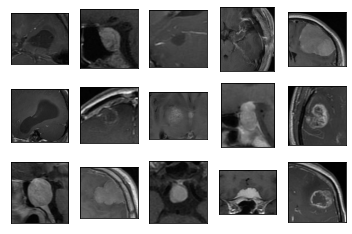

In [7]:
plt.figure()

for i in range(3):
  for j in range(5):
    plt.subplot(3, 5, 1+i*5+j)
    plt.imshow(tumors[i*5+j])
    plt.xticks([])
    plt.yticks([])

plt.show()

In [0]:
tumors_u=[]

for tumor in tumors:
  t = cv2.resize(tumor,
                 dsize=(224,224),
                 interpolation=cv2.INTER_CUBIC)
  tumors_u.append(t)

tumors_u = np.array(tumors_u)

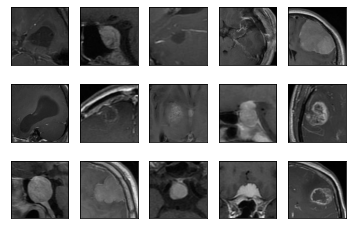

In [81]:
plt.figure()

for i in range(3):
  for j in range(5):
    plt.subplot(3, 5, 1+i*5+j)
    plt.imshow(tumors_u[i*5+j])
    plt.xticks([])
    plt.yticks([])

plt.show()

In [0]:
tumors=tumors_u
y = y-1
y = keras.utils.to_categorical(y, num_classes=3)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(tumors,y,test_size = 0.3)
print(X_train.shape,'\n',X_test.shape)

(2144, 224, 224, 3) 
 (920, 224, 224, 3)


In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [0]:
train_datagen.fit(X_train)

In [0]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=32, seed = 123)
test_generator = test_datagen.flow(X_test, y_test,batch_size=16, seed =123)

In [12]:
# load base model
base_model = VGG16(
    weights='imagenet',
    include_top=False, 
    input_shape=((224,224,3))
)

58892288/58889256 [==============================] - 1s 0us/step


In [13]:
NUM_CLASSES = 3

model = Sequential()
model.add(base_model)

model.add(layers.Flatten(input_shape=X_train.shape[1:]))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(NUM_CLASSES, activation = 'softmax'))

model.layers[0].trainable = False

model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 17,926,467
Trainable params: 3,211,779
Non-trainable params: 14,714,688
_________________________________________________________________


In [14]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=X_train.shape[0] //32,
    shuffle = True,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=X_test.shape[0]//32,
    callbacks=[es]
)

Epoch 1/30
67/67 [==============================] - 47s 704ms/step - loss: 2.0188 - accuracy: 0.7239 - val_loss: 0.1497 - val_accuracy: 0.8705
Epoch 2/30
67/67 [==============================] - 36s 545ms/step - loss: 0.7180 - accuracy: 0.8354 - val_loss: 0.2474 - val_accuracy: 0.8996
Epoch 3/30
67/67 [==============================] - 38s 574ms/step - loss: 0.4547 - accuracy: 0.8764 - val_loss: 0.2345 - val_accuracy: 0.9341
Epoch 4/30
67/67 [==============================] - 37s 549ms/step - loss: 0.3750 - accuracy: 0.8918 - val_loss: 0.1637 - val_accuracy: 0.9330
Epoch 5/30
67/67 [==============================] - 37s 557ms/step - loss: 0.3495 - accuracy: 0.9053 - val_loss: 0.9905 - val_accuracy: 0.9182
Epoch 6/30
67/67 [==============================] - 38s 561ms/step - loss: 0.2895 - accuracy: 0.9230 - val_loss: 0.1271 - val_accuracy: 0.9442
Epoch 7/30
67/67 [==============================] - 37s 558ms/step - loss: 0.2648 - accuracy: 0.9319 - val_loss: 0.0017 - val_accuracy: 0.9455

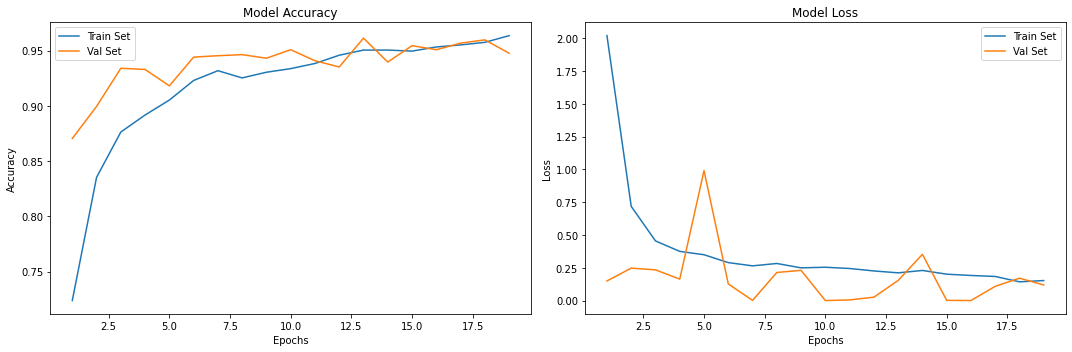

In [15]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

confision matrix

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  plt.figure(figsize=(6,6))
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)
  if normalize:
    cm = cm.astype('float') /cm.sum(axis=1) [:, np.newaxis]
  thresh = cm.max() / 2 
  cm = np.round(cm,2)
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i,cm[i,j],
             horizontalalignment="center",
             color="white" if cm[i,j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show

In [0]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [0]:
y_labels = np.argwhere(y_test == 1)
y_labels = y_labels[:, 1]

Test Accuracy = 0.92


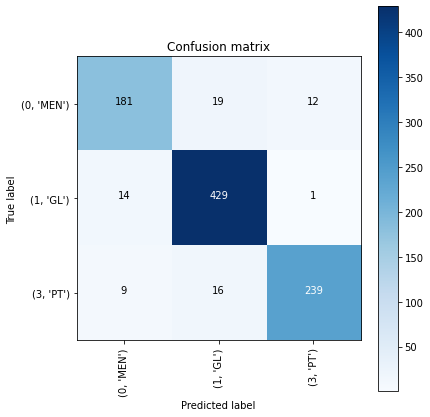

In [56]:
predictions = model.predict_classes(X_test)

accuracy = accuracy_score(y_labels, predictions)
print('Test Accuracy = %.2f' % accuracy)

labels = {0:'MEN', 1: 'GL', 3: 'PT' }

confusion_mat= confusion_matrix(y_labels, predictions)
cm = plot_confusion_matrix(confusion_mat, classes = list(labels.items()), normalize=False)

In [58]:
#total missclassified
len(np.argwhere(y_labels != predictions))

71

In [0]:
model.save('Figshare Tumor mask.h5')

In [0]:
!cp 'brain2 mask vgg16.h5' 'drive/My Drive/'